# Analyzing an exported WhatsApp chat history

### Introduction
Did you ever wonder how much you chat with your best friend or significant other? How many texts do you send per day? How many words per text? What day of the week or time of the day do you text most and which words or emojis are typical for you?

With this notebook we'll find out in no time! In WhatsApp you can export your chat log as a text file (we chose the option without media file export here, which will be shown as `<Media omitted>` in the chat log) and analyze it with this code. For this demonstration I've replaced the texts in a chat with a friend using just Lorem Ipsum text, but retained emojis and `<Media omitted>` markers to get a realistic, yet anonymous example file. For those who wonder who Max Mustermann is; that name is basically the German version of John Doe.
    
Technical note: If there is a line of system information in the text file that is not attributed to one of the chat participants (e.g. "This chat is end-to-end encrypted") check if if got properly removed by the code here in case something looks weird.

### Setup names and reading in the data

Enter the participants names and the filename below and get started.

In [1]:
# enter the chatters' names and the filename here
fullname1 = "Max Mustermann"
fullname2 = "Pascal Bliem"
filename = "WhatsApp Chat with Max Mustermann.txt"

# do you want to export all figures as PNGs?
export = True

In [2]:
# import libraries
import re
import numpy as np
import pandas as pd
# set up plotting environment
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
plt.rcParams['figure.figsize'] = [6,4]
#plt.rcParams['font.size'] = 12
sns.set_style(style="darkgrid")

### Preparing the data
First we'll read in the file content and extract the chatters' names, date and time of a message, and its content. We also do some cleaning of the text, removing the symbols we don't need, and check if the correct number of lines were parsed.

In [3]:
# read the chat file content
with open(filename,"r") as file:
    content = file.read()
# remove the line about end-to-end encryption
WAencr = "Messages to this chat and calls are now secured with end-to-end encryption. Tap for more info."
content = re.sub("\d{2}/\d{2}/\d{4},\s+\d\d:\d\d.+"+WAencr+"\n","",content)

# extract dates, names and text content
dates = re.findall("\d{2}/\d{2}/\d{4},\s+\d\d:\d\d",content)[0:] 
names = re.findall(fullname1+":|"+fullname2+":",content) 
names = [n[:-1] for n in names]# stripping the colon
name1 = fullname1.split()[0]# get first names
name2 = fullname2.split()[0]
texts = re.split("\d{2}/\d{2}/\d{4},\s+\d\d:\d\d",content)[1:]# 0th elements will be empty
texts = [re.sub("\n","",line) for line in texts]# remove newlines
texts = [re.sub("^ -.+: ","",line) for line in texts]# remove senders name in text content

# put individual lists in an array and traspose it so that it'll fit in a data frame
data = np.array([dates,names,texts]).T

# check for same number of parsed units
if (len(texts)!=len(names)) or (len(texts)!=len(dates)):
    print("WARNING: unequal number of dates, sender names, and text messages parsed!\nDates: {}\nNames: {}\nTexts: {}".format(len(dates),len(names),len(texts)))
else:
    print("Successfully parsed {} chat messages".format(len(dates)))

Successfully parsed 13702 chat messages


Now we will put the data in a Pandas data frame for further analysis. We'll already do some aggregation of word count and check for NaN values.

In [4]:
# create a pandas data frame
df = pd.DataFrame(data, columns=["DateTime","Sender","Message"])
# convert the date and time to panda's datetime format
df.DateTime = df.DateTime.apply(lambda x: pd.to_datetime(x,dayfirst=True))

# create new columns with agregate data about message sender and word count
#for name in [name1,name2]:
#    df["From"+name] = np.nan
#    df.loc[df.Sender.str.match(name),"From"+name] = 1
#    df["WordCount"+name] = np.nan
#    df.loc[df.Sender.str.match(name),"WordCount"+name] = df.loc[df.Sender.str.match(name),"Message"].apply(lambda x: len(re.findall("[^\d\s,\.!\?:;]+",x)))

# make a new column that marks each message with 1 for easy aggregation later on
df["MessageCount"] = 1
# make a new column that counts everything that can be seen as a word
df["WordCount"] = df["Message"].apply(lambda x: len(re.findall("[^\d\s,\.!\?:;]+",x)))

if (df.isnull().sum().sum()>0):
    print("WARNING: There are {} Null values, there should be none.".format(df.isnull().sum().sum()))
    print(df[df.isnull()])
else:
    display(df.head())

,DateTime,Sender,Message,MessageCount,WordCount
0,2018-10-19 13:05:00,Pascal Bliem,"Lorem ipsum dolor sit amet, consectetur adipis...",1,80
1,2018-10-19 13:12:00,Max Mustermann,"Lorem ipsum dolor sit amet, consectetur adipis...",1,35
2,2018-10-19 13:15:00,Max Mustermann,"Lorem ipsum dolor sit amet, consectetur adipis...",1,14
3,2018-10-19 13:20:00,Pascal Bliem,"Lorem ipsum dolor sit amet, consectetur adipis...",1,9
4,2018-10-19 13:21:00,Pascal Bliem,"Lorem ipsum dolor sit amet, consectetur adipis...",1,17


If the data frame looks alright, let's start with the fun part - the analysis!

### Analysis - How many ... ?

The most obvious first: How many messages were sent in total by each sender?

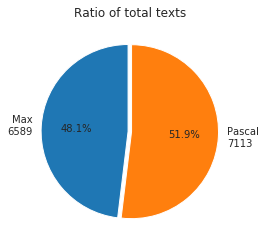

In [5]:
# calculate the number of text messages send by each participant
total_texts = [len(df[df.Sender.str.match(name1)]),len(df[df.Sender.str.match(name2)])]

# plot the quantities in a pie chart
fig1, ax1 = plt.subplots()
ax1 = plt.pie(total_texts,labels=["{}\n{}".format(name1,total_texts[0]),"{}\n{}".format(name2,total_texts[1])], 
              autopct='%1.1f%%',startangle=90,shadow=False,explode=[0.02,0.02])
_ = plt.gca().set_title("Ratio of total texts")

if export:
    plt.savefig("figures/RatioOfTotalTexts.png",dpi=300)

Let's have a look at the average amount of words per text

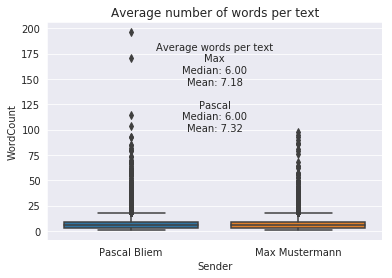

In [6]:
# calculate means and medians for both participants
mean_wrd1 = df.loc[df.Sender.str.match(name1),"WordCount"].mean()
mean_wrd2 = df.loc[df.Sender.str.match(name2),"WordCount"].mean()
median_wrd1 = df.loc[df.Sender.str.match(name1),"WordCount"].median()
median_wrd2 = df.loc[df.Sender.str.match(name2),"WordCount"].median()

# plot the distribution of words per text as box plots
fig1, ax1 = plt.subplots()
sns.boxplot(df.Sender,df.WordCount,ax=ax1)
_ = plt.text(0.5,0.5,"Average words per text\n{}\nMedian: {:.2f}\nMean: {:.2f}\n\n{}\nMedian: {:.2f}\nMean: {:.2f}".format(name1,median_wrd1,mean_wrd1,name2,median_wrd1,mean_wrd2)
             ,transform=ax1.transAxes, ha="center")
ax1.set_title("Average number of words per text")
if export:
    plt.savefig("figures/Averagenumberofwordspertext.png",dpi=300)


Let's look at the distribution of how many texts were send each day.
Is there a significant difference between the distributions of the two chatters?

Normality tests yields p-values of 0.00 % and 0.00 %.
Levene's test yields a p-value of 30.49 %.
Comparing means with Mann Whitney yields a p-value of 40.98 %.


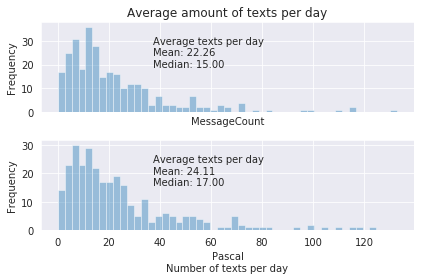

In [7]:
# aggregate data grouped by date and sender
df_date = df.groupby([df.DateTime.dt.date,df.Sender]).agg(sum)
counts1 = df_date.loc[df_date.index.codes[1]==0,"MessageCount"]
counts2 = df_date.loc[df_date.index.codes[1]==1,"MessageCount"]
bins= np.linspace(0, int(max(counts1.max(),counts2.max())),50)

# do some statistical tests to see if there is a statistically significant difference 
# in the texting behaviour of the two participants
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import normaltest
from scipy.stats import gaussian_kde
# check both distributions for normality
no ,p4 = normaltest(counts1)
no ,p5 = normaltest(counts2)
# check for heterogenous variances
le ,p3 = levene(counts1,counts2)
# if the data is not normally distributed (which it is probably not) or the variances of
# the two samples are very different, we cannot use a t-test to compare them and have
# to use non-parametric, rank-based tests e.g. Mann-Whitney-U
mw, p2 = mannwhitneyu(counts1,counts2, use_continuity=True, alternative="two-sided")
print("Normality tests yields p-values of {:.2f} % and {:.2f} %.".format(p4*100,p5*100))
print("Levene's test yields a p-value of {:.2f} %.".format(p3*100))
print("Comparing means with Mann Whitney yields a p-value of {:.2f} %.".format(p2*100))

# plot distributions of "how many texts per day" for each participant
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,sharex=True)
sns.distplot(counts1,bins=bins,kde=False,ax=ax1)
sns.distplot(counts2,bins=bins,kde=False,ax=ax2)
ax1.set_ylabel("Frequency")
ax1.text(0.3,0.5,"Average texts per day\nMean: {:.2f}\nMedian: {:.2f}".format(counts1.mean(),counts1.median()),transform=ax1.transAxes)
ax2.text(0.3,0.5,"Average texts per day\nMean: {:.2f}\nMedian: {:.2f}".format(counts2.mean(),counts2.median()),transform=ax2.transAxes)
ax2.set_ylabel("Frequency")
ax2.set_xlabel(name2+"\nNumber of texts per day")
ax1.set_title("Average amount of texts per day")
plt.tight_layout()
if export:
    plt.savefig("figures/AverageNumberOfTextsPerDay.png",dpi=300)

We can see that there is no statistically significant difference in the amounts of texts send per day by the two chatters in this example.

### Analysis - When ... ?
Now that we know how many texts per day we send on average, let's find out if the amount varies between the different days of the week.

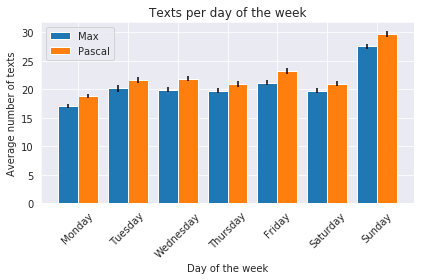

In [8]:
# calc time in weeks over the time span for normalization
numweeks = (df.DateTime.max()-df.DateTime.min()).days/7

# aggregate data for each day of the week
df_day = []
for d in range(0,7):
    dayrow = []
    day = df[df.DateTime.dt.dayofweek==d].groupby([df.DateTime.dt.date,df.Sender]).sum()
    counts1 = day.loc[day.index.codes[1]==0,"MessageCount"]
    counts2 = day.loc[day.index.codes[1]==1,"MessageCount"]
    # calculate sum and standard deviation per user and normalize by number of weeks
    dayrow.append(counts1.sum()/numweeks)
    dayrow.append(counts2.sum()/numweeks)
    dayrow.append(counts1.std()/numweeks)
    dayrow.append(counts2.std()/numweeks)
    df_day.append(dayrow)
# data is stored like [[sum1,sum2,std1,std2],...]
df_day = np.array(df_day)

# plot the results in a bar plot with the standard deviation as whiskers
fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
plt.bar(np.arange(7)-0.4,df_day[:,0],yerr=df_day[:,2],width=0.4,label=name1,align='edge')
plt.bar(np.arange(7),df_day[:,1],yerr=df_day[:,3],width=0.4,label=name2,align='edge')
plt.gca().set_xlabel("Day of the week")
plt.gca().set_ylabel("Average number of texts")
plt.gca().set_title("Texts per day of the week")
plt.gca().set_xticklabels(["","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",],rotation=45)
plt.legend()
plt.tight_layout()
if export:
    plt.savefig("figures/TextsPerDayOfTheWeek.png",dpi=300)

It looks lie we are texting more in our free time on Sundays and less on Mondays when we're back to work :)

Now how about our texting behavior according to the hour of the day?

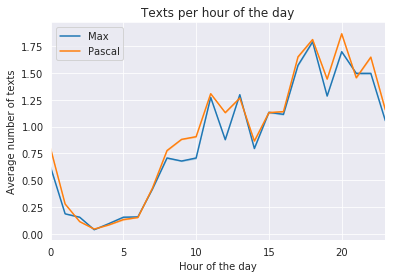

In [9]:
# calc time in days over the time span for normalization
numdays = (df.DateTime.max()-df.DateTime.min()).days

# aggregate data for each hour of the day
df_hour = []
for h in range(0,24):
    hourrow = []
    hour = df[df.DateTime.dt.hour==h].groupby([df.DateTime.dt.date,df.Sender]).sum()
    counts1 = hour.loc[hour.index.codes[1]==0,"MessageCount"]
    counts2 = hour.loc[hour.index.codes[1]==1,"MessageCount"]
    # calculate sum and standard deviation per user and normalize by number of days
    hourrow.append(counts1.sum()/numdays)
    hourrow.append(counts2.sum()/numdays)
    hourrow.append(counts1.std()/numdays)
    hourrow.append(counts2.std()/numdays)
    df_hour.append(hourrow)
# data is stored like [[sum1,sum2,std1,std2],...]
df_hour = np.array(df_hour)

# plot the results in a line plot with the standard deviation as bands around the line
fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
sns.lineplot(np.arange(24),df_hour[:,0],ax=ax1,label=name1)
plt.fill_between(x=np.arange(24),y1=df_hour[:,0]+df_hour[:,2],y2=df_hour[:,0]-df_hour[:,2],alpha=0.3)
sns.lineplot(np.arange(24),df_hour[:,1],ax=ax1,label=name2)
plt.fill_between(x=np.arange(24),y1=df_hour[:,1]+df_hour[:,3],y2=df_hour[:,1]-df_hour[:,3],alpha=0.3)
plt.gca().set_xlim([0,23])
plt.gca().set_xlabel("Hour of the day")
plt.gca().set_ylabel("Average number of texts")
_ = plt.gca().set_title("Texts per hour of the day")
if export:
    plt.savefig("figures/TextsPerHourOfTheDay.png",dpi=300)

Unsurprisingly, we don't text so much in the middle of the night, a bit more during the day, and a lot more after work in the afternoon and evening.

Who usually gets up earlier in the morning and sends the first text of the day?

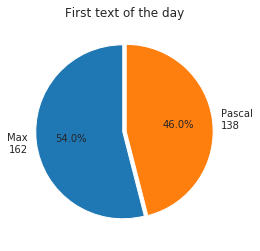

In [10]:
# see who was the first sender of each day
first_sender = []
for d in df.DateTime.dt.date.unique():
    first_sender.append(df[df.DateTime.dt.date == d].iloc[0].Sender)
# count how many first texts of the day each participant sent
first_sender = pd.Series(first_sender).value_counts().values

# plot the results in a pie chart
fig1, ax1 = plt.subplots()
ax1 = plt.pie(first_sender,labels=["{}\n{}".format(name1,first_sender[0]),"{}\n{}".format(name2,first_sender[1])], 
              autopct='%1.1f%%',startangle=90,shadow=False,explode=[0.02,0.02])
_ = plt.gca().set_title("First text of the day")

if export:
    plt.savefig("figures/FirstTextOfTheDay.png",dpi=300)


Looks like my friend tends to usually get up a bit earlier than me.

Now how did our monthly chat behavior develop over the entire time we are connected on WhatsApp?

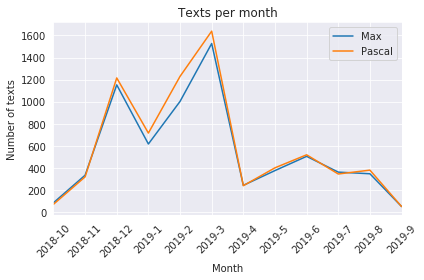

In [11]:
# sum up the texts for each month
df_months = df.copy().set_index("DateTime",drop=True)
df_months = df_months.groupby([pd.Grouper(freq="M"),"Sender"]).sum()
counts1 = df_months.loc[df_months.index.codes[1]==0,"MessageCount"]
counts2 = df_months.loc[df_months.index.codes[1]==1,"MessageCount"]

# get months for x-axis in plot
months = range(len(df_months.index.levels[0]))
months_labels = df_months.index.levels[0].map(lambda x: str(x.year)+"-"+str(x.month))
# plot the data as line plot
fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
sns.lineplot(months,counts1,ax=ax1,label=name1)
sns.lineplot(months,counts2,ax=ax1,label=name2)
plt.gca().set_xlim(months[0],months[-1])
plt.gca().set_xlabel("Month")
plt.gca().set_ylabel("Number of texts")
plt.gca().set_title("Texts per month")
plt.gca().set_xticks(months)
plt.gca().set_xticklabels(months_labels,rotation=45)
plt.legend()
plt.tight_layout()
if export:
    plt.savefig("figures/TextsPerMonth.png",dpi=300)

My friend and I started texting a lot after we first met and then around April 2019 there is a steep drop which corresponds to me moving into my friend's neighborhood which meant we could talk a lot more face-to-face.

### Analysis - Which words ... ?
Let's collect all words, emojis, and count how many media files were sent

In [12]:
words = [[],[]]
emojis = [[],[]]
media_cnt =[0,0]
# go through all texts
for i,text in df.Message.iteritems():
    # if "<Media omitted>" is found it was a send media file, just increase the media count
    if re.match("<Media omitted>",text):
        text = re.sub("<Media omitted>","",text)
        if re.match(name1,df.loc[i,"Sender"]):
            media_cnt[0] += 1
        else:
            media_cnt[1] += 1
    #split text into words    
    for word in text.split():
        # if it's an emoji, add to emoji list
        if re.match("[\u263a-\U0001f645]",word,re.UNICODE):
            if re.match(name1,df.loc[i,"Sender"]):
                emojis[0].append(word)
            else:
                emojis[1].append(word)
        # if it's a word, add to word list
        elif re.match("[^\d\s\.\,\;\:\?\!\+\-\*]+",word):
            if re.match(name1,df.loc[i,"Sender"]):
                words[0].append(word)
            else:
                words[1].append(word)

Now we'll make some plots about the favorite words and emojis

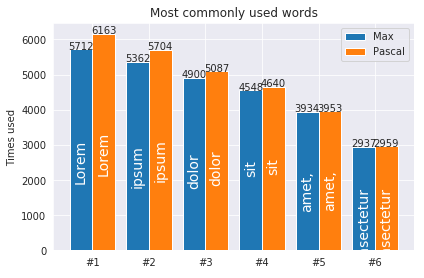

In [13]:
# count the words and see which are used most often
counts = np.concatenate(( 
         np.array(pd.Series(words[0]).value_counts().values[:6]).reshape(-1,1),
         np.array(pd.Series(words[1]).value_counts().values[:6]).reshape(-1,1)),
         axis=1)
top_words= np.concatenate(( 
         np.array(pd.Series(words[0]).value_counts().index[:6]).reshape(-1,1),
         np.array(pd.Series(words[1]).value_counts().index[:6]).reshape(-1,1)),
         axis=1)

# plot the results as a bar chart
fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
bars1 = plt.bar(np.arange(6)-0.4,counts[:,0],width=0.4,label=name1,align='edge')
bars2 = plt.bar(np.arange(6),counts[:,1],width=0.4,label=name2,align='edge')

# annotate the bars with the words and their counts
for i,bars in enumerate([bars1,bars2]):
    for j,bar in  enumerate(bars):
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height+5),ha="center")
        ax1.annotate('{}'.format(top_words[j,i]),
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),ha="center",color="w",fontsize=14,rotation=90)


plt.gca().set_xlabel("")
plt.gca().set_ylabel("Times used")
plt.gca().set_title("Most commonly used words")
plt.gca().set_xticklabels(["","#1","#2","#3","#4","#5","#6"],rotation=0)
plt.legend()
plt.tight_layout()
if export:
    plt.savefig("figures/MostCommonlyUsedWords.png",dpi=300)



Now let's  do the same for the emojis.

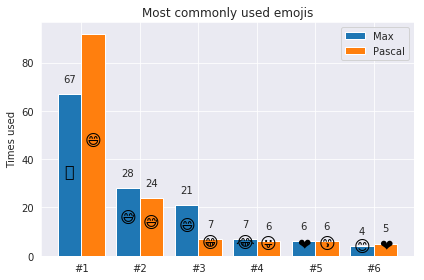

In [14]:
# count the emojis and see which are used most often
ecounts = np.concatenate(( 
         np.array(pd.Series(emojis[0]).value_counts().values[:6]).reshape(-1,1),
         np.array(pd.Series(emojis[1]).value_counts().values[:6]).reshape(-1,1)),
         axis=1)
top_emojis= np.concatenate(( 
         np.array(pd.Series(emojis[0]).value_counts().index[:6]).reshape(-1,1),
         np.array(pd.Series(emojis[1]).value_counts().index[:6]).reshape(-1,1)),
         axis=1)

# plot the results as a bar chart
fig, (ax1) = plt.subplots(nrows=1,ncols=1,)
bars1 = plt.bar(np.arange(6)-0.4,ecounts[:,0],width=0.4,label=name1,align='edge')
bars2 = plt.bar(np.arange(6),ecounts[:,1],width=0.4,label=name2,align='edge')

# annotate the bars with the emojis and their counts
for i,bars in enumerate([bars1,bars2]):
    for j,bar in  enumerate(bars):
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height+5),ha="center")
        ax1.annotate('{}'.format(top_emojis[j,i]),
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),ha="center",color="k",fontsize=16,rotation=0)

plt.gca().set_xlabel("")
plt.gca().set_ylabel("Times used")
plt.gca().set_title("Most commonly used emojis")
plt.gca().set_xticklabels(["","#1","#2","#3","#4","#5","#6"],rotation=0)
plt.legend()
plt.tight_layout()
if export:
    plt.savefig("figures/MostCommonlyUsedEmojis.png",dpi=300)


How many media files did we send?

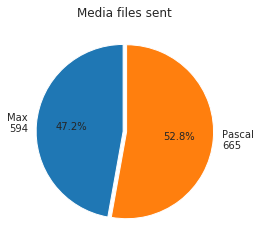

In [15]:
# plot the media file count in a pie chart
fig1, ax1 = plt.subplots()
ax1 = plt.pie(media_cnt,labels=["{}\n{}".format(name1,media_cnt[0]),"{}\n{}".format(name2,media_cnt[1])], 
              autopct='%1.1f%%',startangle=90,shadow=False,explode=[0.02,0.02])
plt.gca().set_title("Media files sent")

if export:
    plt.savefig("figures/MediaFilesSent.png",dpi=300)

That was a lot of fun actually; let me know if you got any other ideas that could be interesting to analyze in WhatsApp chat logs.
Thanks for following me through this project!